# Sagemaker: model training and deployment 

In [12]:
# importing the necossery liberay 
import sagemaker
from sagemaker.tensorflow import TensorFlow
import os

import numpy as np
import pandas as pd
from sklearn.utils import class_weight

from Data import Data # Data processing libery 

 Data is a class for preprocessing the raw_data in the required format for the model training 

## Data set : Downloading and preprocessing 

After uploading the dataset into the S3 bucket we will download it to the local directory for preprocessing 

In [13]:
# Downloading data from S3

import boto3
 
from sagemaker import get_execution_role
role = get_execution_role()
 
my_bucket = 'facesong'
orig_file = 'Raw_data/icml_face_data.csv.zip'
dest_file = 'icml_face_data.csv.zip'
 
s3 = boto3.resource('s3')
s3.Bucket(my_bucket).download_file(orig_file, dest_file)

### Dataset

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

ref : s3/readme.md

In [14]:
df = pd.read_csv("icml_face_data.csv.zip")

In [2]:
import pandas as pd
df = pd.read_csv("/home/vaibhav/FaceSong/icml_face_data.csv.zip")

In [3]:
df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1    Usage   35887 non-null  object
 2    pixels  35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


from the above info, we can see that there are about 35887 2D images for the training and testing 
and dataset consists of 3 columns for emotion (int 0-6 ) Usage and pixels in the object

In [6]:
df.isnull() #checking for the null values

,emotion,Usage,pixels
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
35882,False,False,False
35883,False,False,False
35884,False,False,False
35885,False,False,False


### Visulization

plotting the distribution of the classes 

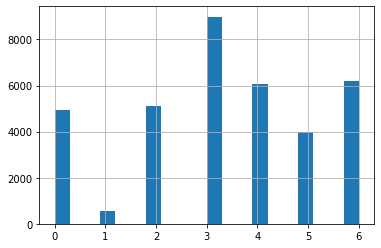

In [15]:
df['emotion'].hist(bins = 20)



##### from the above representation we can see that this is an unbalanced dataset the distribution of the classes is unequal 

##### Because of the unbiased dataset, we might get wrong results in the real world scenario 

##### To solve this problem we will set up the class weights for each class during the training of the model
##### this will help the model to train with the biased dataset 



### Preprocessing

In [16]:
# prepross the data

# Data.py inlcludes the proprocessing steps 

data = Data()
Train_X , Train_y , Test_X ,Test_y = data.Get_data()

In [17]:
# save the preprossesd data in the local dir 

data_dir = os.path.join(os.getcwd(), 'data')
os.makedirs(data_dir, exist_ok=True)

train_dir = os.path.join(os.getcwd(), 'data/train')
os.makedirs(train_dir, exist_ok=True)

test_dir = os.path.join(os.getcwd(), 'data/test')
os.makedirs(test_dir, exist_ok=True)


np.save(os.path.join(train_dir, 'Train_X.npy'), Train_X)
np.save(os.path.join(train_dir, 'Train_y.npy'),  Train_y.astype('float32'))
np.save(os.path.join(test_dir, 'Test_X.npy'), Test_X)
np.save(os.path.join(test_dir, 'Test_y.npy'), Test_y.astype('float32'))

### Upload the preprocessed  data to s3

In [18]:

# Upload the preprossed data to s3 

s3_prefix = 'facesong' 
Sagemaker_session = sagemaker.Session()


traindata_s3_prefix = '{}/data/train'.format(s3_prefix)
testdata_s3_prefix = '{}/data/test'.format(s3_prefix)

train_s3 = Sagemaker_session.upload_data(path='./data/train/', key_prefix=traindata_s3_prefix)
test_s3 = Sagemaker_session.upload_data(path='./data/test/', key_prefix=testdata_s3_prefix)

inputs = {'train':train_s3, 'test': test_s3} # locations of the data 

In [19]:
print(inputs) # input params to the model

{'train': 's3://sagemaker-us-east-1-478270364551/facesong/data/train', 'test': 's3://sagemaker-us-east-1-478270364551/facesong/data/test'}


## Training the model 

Train.py has the python script for the development and training of the model 

## Model Architecture 

 
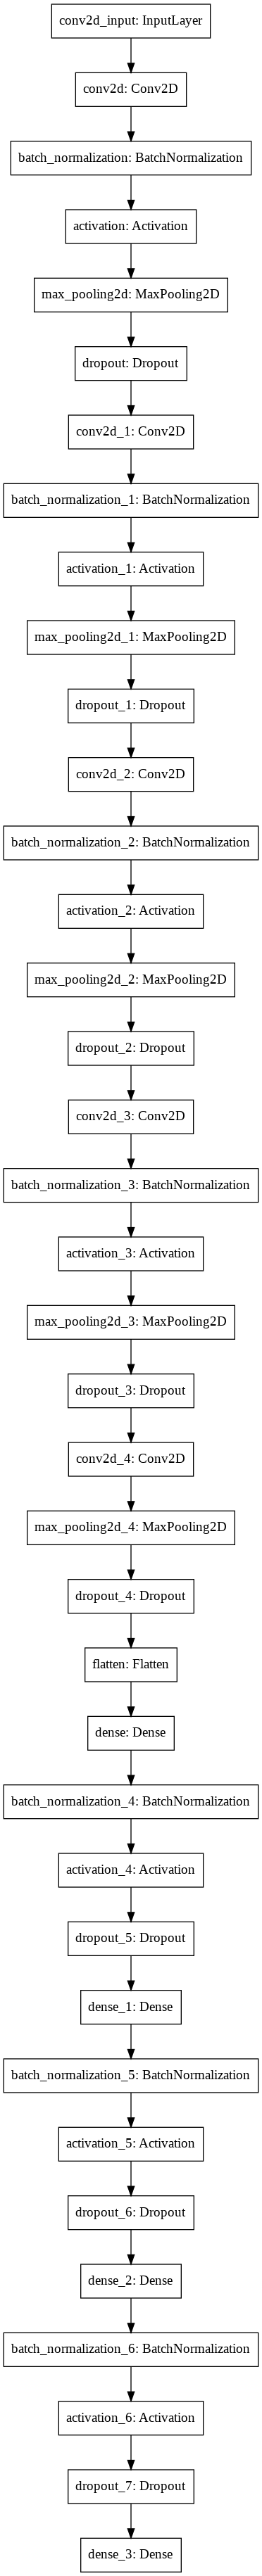

In [20]:
!pygmentize 'train.py'

import argparse
import os
import numpy as np
import json

# importing neccossory liberies
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout ,BatchNormalization,Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from sklearn.utils import class_weight


def get_model():
    """
    creates a simpel CNN arcitechure

    Parameters:
    Null

    Returns:

    kears Modle arcitecture

   """

    model = Sequential()

    # convolution layers
    model.add(Conv2D(64,(3,3),padding='same',input_shape=(48,48,1)) )
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model

## create a new SageMaker TensorFlow job using sagemaker.tensorflow class

In [21]:


from sagemaker.tensorflow import TensorFlow


estimator = TensorFlow(entry_point='train.py',
                             role=role,
                             train_instance_count=1,
                             train_instance_type='ml.p2.xlarge',
                             framework_version='2.1.0',
                             py_version='py3',
                             #hyperparameters={'class_weights' : class_weights},
                       
                             distributions={'parameter_server': {'enabled': True}})

distributions has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### train the model 
### the estimator will download the container image when running for the first time 
### and it may take a long time to run this cell 

In [22]:

estimator.fit(inputs)

2021-01-05 10:11:16 Starting - Starting the training job...
2021-01-05 10:11:39 Starting - Launching requested ML instancesProfilerReport-1609841476: InProgress
.........
2021-01-05 10:13:00 Starting - Preparing the instances for training......
2021-01-05 10:14:12 Downloading - Downloading input data...
2021-01-05 10:14:42 Training - Downloading the training image.........
2021-01-05 10:16:10 Training - Training image download completed. Training in progress..2021-01-05 10:16:15,777 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2021-01-05 10:16:16,373 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {
        "sagemaker_parameter_server_enabled": true
    },
    "channel_input_dirs": {
        "test": "/opt/ml/input/data/test",
        "train": "/opt/ml/input/data/train"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "ho

## Deploy 

In [23]:

# deploying th eendpoint 

predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-------------!

In [24]:
# display endppoint 
predictor.endpoint

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


'tensorflow-training-2021-01-05-10-27-43-167'

# Cleaning up


We will not delete the endpoint right now as we need this endpoint for deployment 
but as soon as we are done with it,  we will delete the endpoint using the console.
This is very important To avoid incurring charges to your AWS account

In [ ]:
#sagemaker_session.delete_endpoint(predictor.endpoint)